In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [12]:
  # Load the dataset
df = pd.read_csv('AAPL_processed.csv')

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.head(50)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        5031 non-null   datetime64[ns]
 1   adj close   5031 non-null   float64       
 2   SMA         5022 non-null   float64       
 3   BB%         5012 non-null   float64       
 4   RSI         5018 non-null   float64       
 5   CCI         5012 non-null   float64       
 6   PPO         5006 non-null   float64       
 7   PPO_signal  4998 non-null   float64       
 8   Signal      5031 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 353.9 KB


In [16]:
# Check for missing values
print(df.isnull().sum())

date           0
adj close      0
SMA            9
BB%           19
RSI           13
CCI           19
PPO           25
PPO_signal    33
Signal         0
dtype: int64


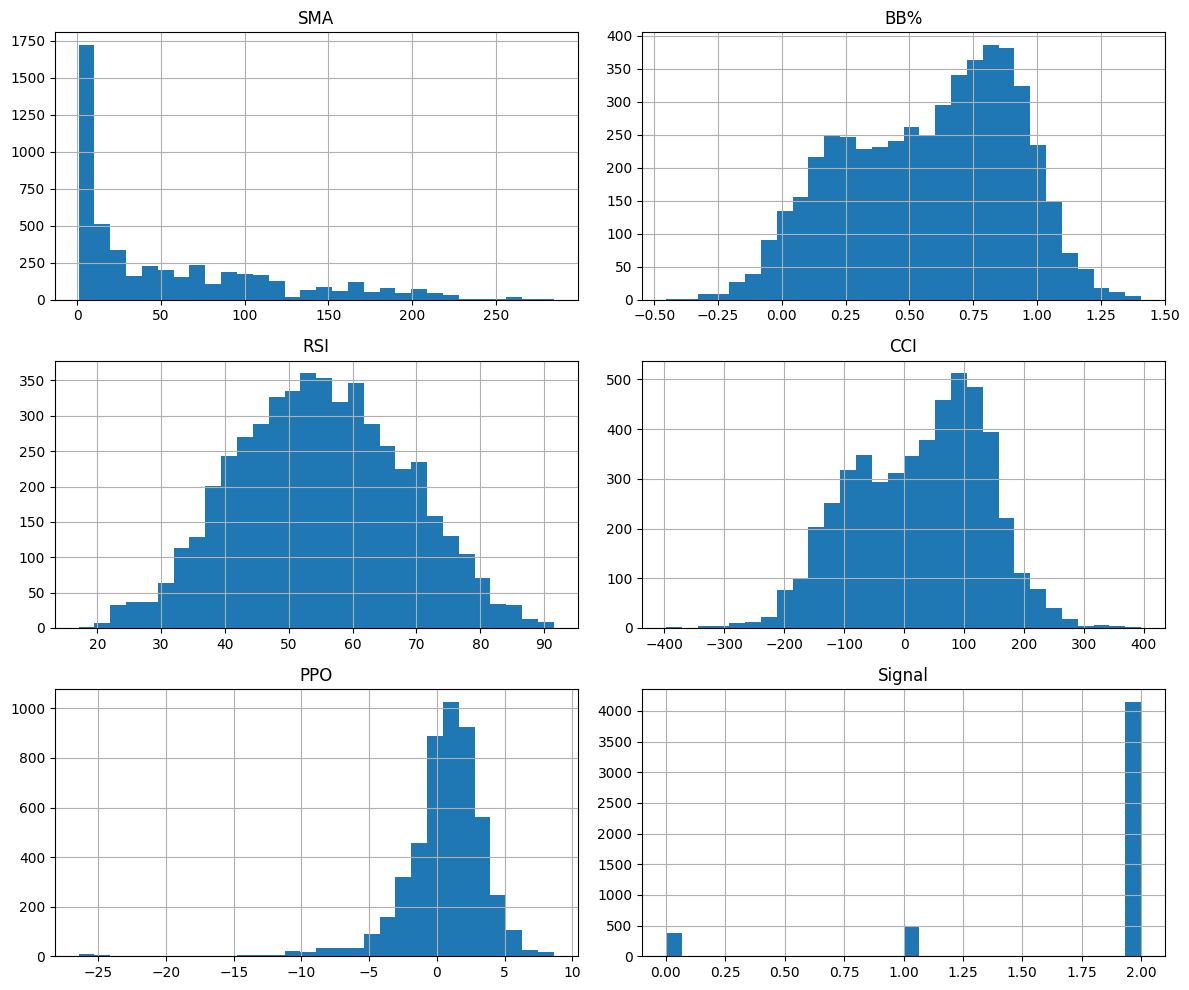

In [17]:
# Plot distribution of the features and the target
df[['SMA', 'BB%', 'RSI', 'CCI', 'PPO', 'Signal']].hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

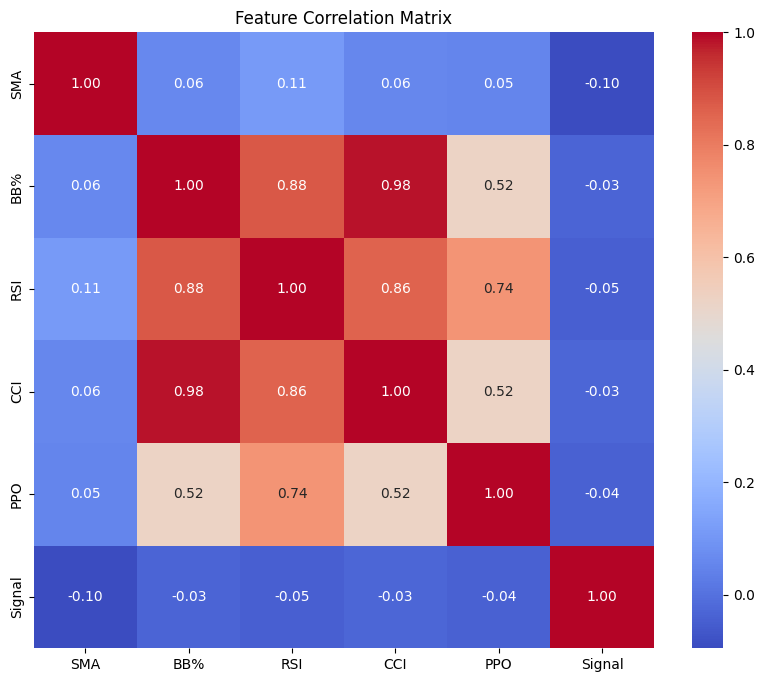

In [18]:
# Correlation matrix
correlation_matrix = df[['SMA', 'BB%', 'RSI', 'CCI', 'PPO', 'Signal']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [19]:
# Check correlation with the target variable
print("Correlations with the Signal:")
print(correlation_matrix["Signal"].sort_values(ascending=False))

Correlations with the Signal:
Signal    1.000000
CCI      -0.031041
BB%      -0.031491
PPO      -0.041678
RSI      -0.047297
SMA      -0.095603
Name: Signal, dtype: float64


In [20]:
# Group by year and count the records for each year
records_by_year = df.groupby(df['date'].dt.year).size()

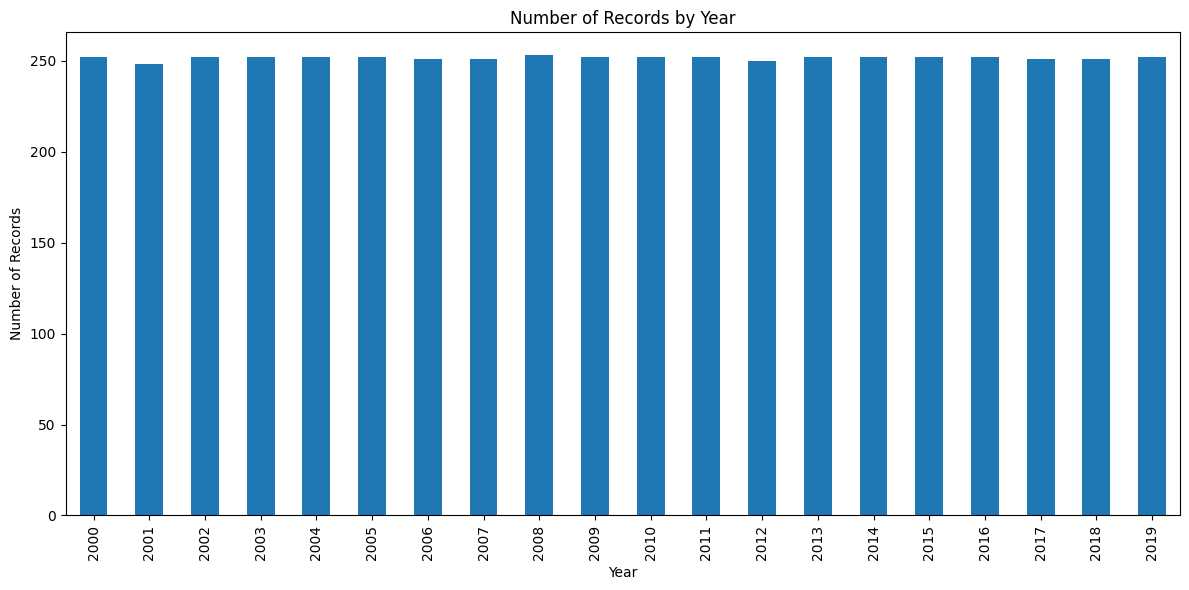

In [21]:
# Plotting the number of records by year
plt.figure(figsize=(12, 6))
records_by_year.plot(kind='bar')
plt.title('Number of Records by Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

In [49]:
# Checking label distribution in the dataset
label_distribution = df['Signal'].value_counts(normalize=True)
print("Label Distribution:")
print(label_distribution)

Label Distribution:
Signal
2    0.824886
1    0.098390
0    0.076724
Name: proportion, dtype: float64


In [28]:
# Split the data into features (X) and target (y), excluding 'adj close' and 'PPO_signal'
X = df[['SMA', 'BB%', 'RSI', 'CCI', 'PPO']]
y = df['Signal']

In [29]:
# Split the data into train and test sets
train_mask = (df['date'] < '2017-01-01')
test_mask = (df['date'] >= '2017-01-01') & (df['date'] <= '2019-12-31')

In [30]:
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

In [31]:
len(X_train), len(X_test)

(4277, 754)

In [32]:
# Initialize XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [33]:
# Fit the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [34]:
# Predict on the testing data
y_pred = model.predict(X_test)

In [35]:
# Evaluate the model using Mean Absolute Error
mAE = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mAE:.4f}")

Mean Absolute Error: 0.3369


In [51]:
cm_full = confusion_matrix(y_test, y_pred)

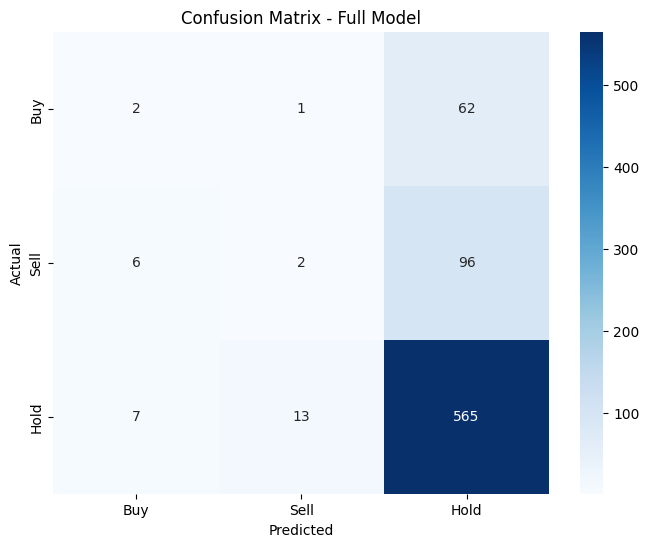

In [52]:
# Plotting the confusion matrix for the full model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', xticklabels=['Buy', 'Sell', 'Hold'], yticklabels=['Buy', 'Sell', 'Hold'])
plt.title('Confusion Matrix - Full Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [53]:
# Classification report for the full model
report_full = classification_report(y_test, y_pred, target_names=['Buy', 'Sell', 'Hold'])
print("Classification Report for Full Model:")
print(report_full)

Classification Report for Full Model:
              precision    recall  f1-score   support

         Buy       0.13      0.03      0.05        65
        Sell       0.12      0.02      0.03       104
        Hold       0.78      0.97      0.86       585

    accuracy                           0.75       754
   macro avg       0.35      0.34      0.32       754
weighted avg       0.64      0.75      0.68       754



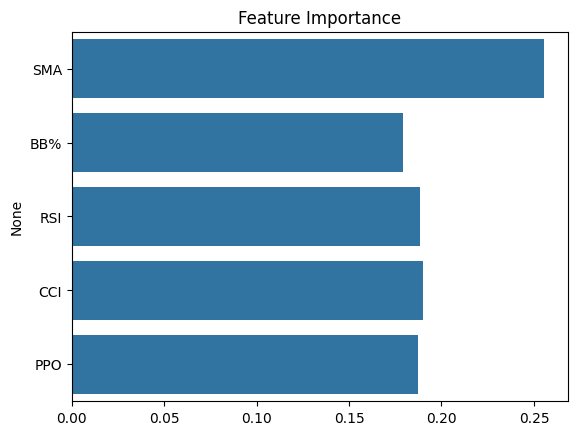

In [36]:
# Feature importance
feature_importance = model.feature_importances_
sns.barplot(x=feature_importance, y=X.columns)
plt.title('Feature Importance')
plt.show()

In [37]:
# Split the data into reduced features (X) and target (y)
X_reduced = df[['SMA', 'BB%', 'PPO']]
y = df['Signal']

In [38]:
X_train_reduced, y_train = X_reduced[train_mask], y[train_mask]
X_test_reduced, y_test = X_reduced[test_mask], y[test_mask]

In [39]:
# Initialize XGBoost classifier
reduced_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [40]:
# Fit the reduced model on the training data
reduced_model.fit(X_train_reduced, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [41]:
# Predict on the testing data
y_pred_reduced = reduced_model.predict(X_test_reduced)

In [42]:
# Evaluate the reduced model using Mean Absolute Error
mAE_reduced = mean_absolute_error(y_test, y_pred_reduced)
print(f"Mean Absolute Error (Reduced Model): {mAE_reduced:.4f}")

Mean Absolute Error (Reduced Model): 0.3236


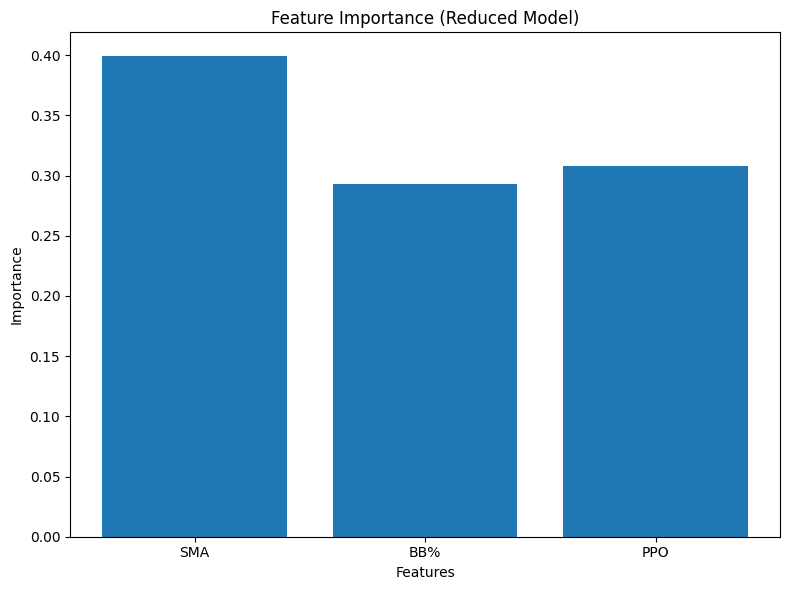

In [43]:
# Feature importance for the reduced model
feature_importance_reduced = reduced_model.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(X_reduced.columns, feature_importance_reduced)
plt.title('Feature Importance (Reduced Model)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [54]:
cm_reduced = confusion_matrix(y_test, y_pred_reduced)

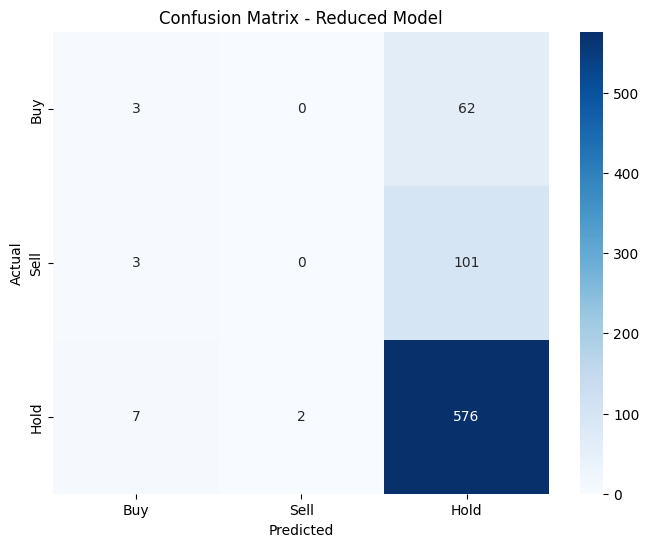

In [55]:
# Plotting the confusion matrix for the reduced model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_reduced, annot=True, fmt='d', cmap='Blues', xticklabels=['Buy', 'Sell', 'Hold'], yticklabels=['Buy', 'Sell', 'Hold'])
plt.title('Confusion Matrix - Reduced Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [56]:
# Classification report for the reduced model
report_reduced = classification_report(y_test, y_pred_reduced, target_names=['Buy', 'Sell', 'Hold'])
print("Classification Report for Reduced Model:")
print(report_reduced)

Classification Report for Reduced Model:
              precision    recall  f1-score   support

         Buy       0.23      0.05      0.08        65
        Sell       0.00      0.00      0.00       104
        Hold       0.78      0.98      0.87       585

    accuracy                           0.77       754
   macro avg       0.34      0.34      0.32       754
weighted avg       0.62      0.77      0.68       754



In [59]:
# Define the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [60]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [61]:
# Setup the grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)


In [62]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

In [63]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 50, 'subsample': 0.9}
Best accuracy found:  0.36655151201988145


In [66]:
# Use the best estimator to make predictions
y_pred_best = grid_search.best_estimator_.predict(X_test)

In [67]:
# Calculate Mean Absolute Error
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f"Mean Absolute Error: {mae_best:.4f}")

Mean Absolute Error: 0.3103


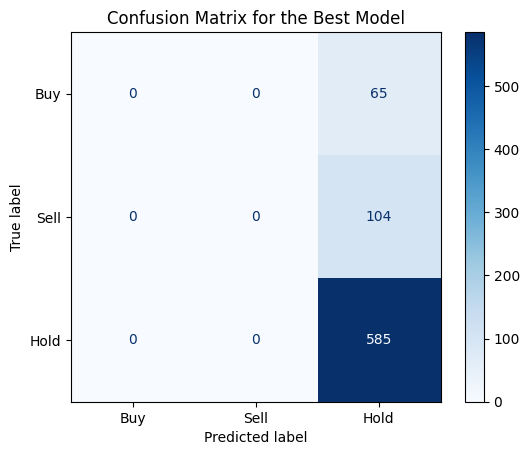

In [68]:
# Generate confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm_best, display_labels=['Buy', 'Sell', 'Hold']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for the Best Model')
plt.show()

<ipython-input-70-bdbde668ce27>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_best, y=X_train.columns, palette='Blues_d')


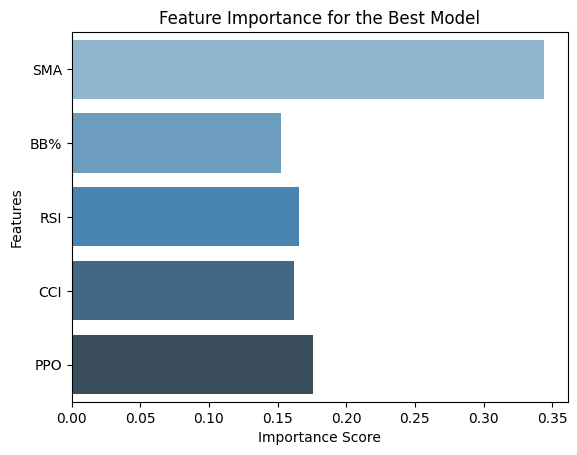

In [70]:
# Feature importance for the best model
feature_importance_best = grid_search.best_estimator_.feature_importances_
sns.barplot(x=feature_importance_best, y=X_train.columns, palette='Blues_d')
plt.title('Feature Importance for the Best Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()